Load Packages
===============

In [1]:
%matplotlib inline
import os
import struct
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms

Load Data:
===============

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
BatchSize = 100

trainset = torchvision.datasets.MNIST(root='./MNIST', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize,
                                          shuffle=True, num_workers=4) # Creating dataloader

testset = torchvision.datasets.MNIST(root='./MNIST', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BatchSize,
                                         shuffle=False, num_workers=4) # Creating dataloader

classes = ('zero', 'one', 'two', 'three',
           'four', 'five', 'six', 'seven', 'eight', 'nine')

In [3]:
# Check availability of GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')

GPU is available!


Define the Autoencoder:
===============

In [4]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import copy


class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.ReLU(),
            nn.Linear(400, 256),
            nn.ReLU())
        self.decoder = nn.Sequential(
            nn.Linear(256, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.ReLU())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


net = autoencoder()
print(net)

if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()
        
init_weights = copy.deepcopy(net.encoder[0].weight.data)

autoencoder (
  (encoder): Sequential (
    (0): Linear (784 -> 400)
    (1): ReLU ()
    (2): Linear (400 -> 256)
    (3): ReLU ()
  )
  (decoder): Sequential (
    (0): Linear (256 -> 400)
    (1): ReLU ()
    (2): Linear (400 -> 784)
    (3): ReLU ()
  )
)


Train Autoencoder:
===========

In [5]:
iterations = 10
learning_rate = 0.9
criterion = nn.MSELoss()

for epoch in range(iterations):  # loop over the dataset multiple times

    runningLoss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        # wrap them in Variable
        if use_gpu:
            inputs = Variable(inputs.view(-1, 28*28).double()).cuda()
        else:
            inputs = Variable(inputs.view(-1, 28*28).double())

        net.zero_grad()  # zeroes the gradient buffers of all parameters
        outputs = net(inputs) # forward 
        loss = criterion(outputs, inputs) # calculate loss
        loss.backward() #  backpropagate the loss
        for f in net.parameters():
            f.data.sub_(f.grad.data * learning_rate) # weight = weight - learning_rate * gradient (Update Weights)
        runningLoss += loss.data[0]
        
    print('At Iteration : %d / %d  ;  Mean-Squared Error : %f'%(epoch + 1,iterations,
                                                                        runningLoss/(60000/BatchSize)))
print('Finished Training')

At Iteration : 1 / 10  ;  Mean-Squared Error : 0.075260
At Iteration : 2 / 10  ;  Mean-Squared Error : 0.051049
At Iteration : 3 / 10  ;  Mean-Squared Error : 0.039224
At Iteration : 4 / 10  ;  Mean-Squared Error : 0.033254
At Iteration : 5 / 10  ;  Mean-Squared Error : 0.029229
At Iteration : 6 / 10  ;  Mean-Squared Error : 0.026634
At Iteration : 7 / 10  ;  Mean-Squared Error : 0.024503
At Iteration : 8 / 10  ;  Mean-Squared Error : 0.022839
At Iteration : 9 / 10  ;  Mean-Squared Error : 0.021808
At Iteration : 10 / 10  ;  Mean-Squared Error : 0.020591
Finished Training


Testing Autoencoder Performance:
=================

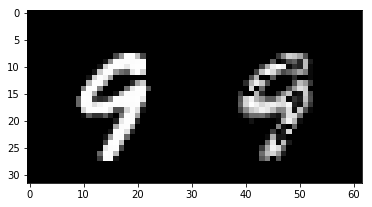

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

if use_gpu:
    outImg = net(Variable((images[0].view(-1,28*28).double().cuda()))).data
    outImg = outImg.view(-1,28,28).cpu()
else:
    outImg = net(Variable((images[0].view(-1,28*28).double()))).data
    outImg = outImg.view(-1,28,28).cpu()

dispImg = torch.Tensor(2,1,28,28)
dispImg[0] = images[0]
dispImg[1] = outImg

# show images
imshow(torchvision.utils.make_grid(dispImg))


Encoder Weights Visualization:
=======================

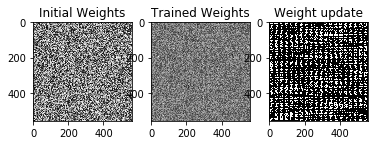

In [7]:
trained_weights = copy.deepcopy(net.encoder[0].weight.data)

init_weights = (1 + init_weights)*127.5
trained_weights = (1 + trained_weights)*127.5


if use_gpu:
    init_weights = init_weights.view(-1,28*20,28*20).byte().cpu()
    trained_weights = trained_weights.view(-1,28*20,28*20).byte().cpu()
else:
    init_weights = init_weights.view(-1,28*20,28*20).byte()
    trained_weights = trained_weights.view(-1,28*20,28*20).byte()

d_weights = init_weights - trained_weights 

fig = plt.figure()
plot=fig.add_subplot(1,3,1)
img = np.array(init_weights.numpy())[0]
plot.set_title('Initial Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,2)
img = np.array(trained_weights.numpy())[0]
plot.set_title('Trained Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,3)
img = np.array(d_weights.numpy())[0]
plot.set_title('Weight update')
imgplot = plt.imshow(img,cmap='gray')
plt.show()

Modifying the autoencoder for classification: 
================================

In [8]:

# Removing the decoder module from the autoencoder
new_classifier = nn.Sequential(*list(net.children())[:-1])
net = new_classifier
# Adding linear layer for 10-class classification problem
net.add_module('classifier', nn.Sequential(nn.Linear(256, 10),nn.LogSoftmax()))
print(net)
if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()
# Copying initial weights  for visualization
cll_weights = copy.deepcopy(net[0][0].weight.data)
init_classifier_weights = copy.deepcopy(net.classifier[0].weight.data)

Sequential (
  (0): Sequential (
    (0): Linear (784 -> 400)
    (1): ReLU ()
    (2): Linear (400 -> 256)
    (3): ReLU ()
  )
  (classifier): Sequential (
    (0): Linear (256 -> 10)
    (1): LogSoftmax ()
  )
)


Train Classifier:
===========

In [9]:
iterations = 10
learning_rate = 0.1
criterion = nn.CrossEntropyLoss()

for epoch in range(iterations):  # loop over the dataset multiple times

    runningLoss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        # wrap them in Variable
        if use_gpu:
            inputs, labels = Variable(inputs.view(-1, 28*28).double()).cuda(), Variable(labels).cuda()
        else:
            inputs, labels = Variable(inputs.view(-1, 28*28).double()), Variable(labels)

        net.zero_grad()  # zeroes the gradient buffers of all parameters
        outputs = net(inputs) # forward 
        loss = criterion(outputs, labels) # calculate loss
        loss.backward() #  backpropagate the loss
        for f in net.parameters():
            f.data.sub_(f.grad.data * learning_rate) # weight = weight - learning_rate * gradient (Update Weights)
        runningLoss += loss.data[0]
        correct = 0
        total = 0
    for data in testloader:
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.view(-1, 28*28).double()).cuda(), labels.cuda()
        else:
            inputs, labels = Variable(inputs.view(-1, 28*28).double()), labels
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    print('At Iteration : %d / %d  ;  Train Error : %f ;Test Accuracy : %f'%(epoch + 1,iterations,
                                                                        runningLoss/(60000/BatchSize),100 * correct /float(total)))
print('Finished Training')

At Iteration : 1 / 10  ;  Train Error : 0.429115 ;Test Accuracy : 92.850000
At Iteration : 2 / 10  ;  Train Error : 0.215412 ;Test Accuracy : 94.940000
At Iteration : 3 / 10  ;  Train Error : 0.154658 ;Test Accuracy : 96.090000
At Iteration : 4 / 10  ;  Train Error : 0.121746 ;Test Accuracy : 96.750000
At Iteration : 5 / 10  ;  Train Error : 0.099610 ;Test Accuracy : 96.920000
At Iteration : 6 / 10  ;  Train Error : 0.083372 ;Test Accuracy : 97.130000
At Iteration : 7 / 10  ;  Train Error : 0.072222 ;Test Accuracy : 97.590000
At Iteration : 8 / 10  ;  Train Error : 0.061952 ;Test Accuracy : 97.640000
At Iteration : 9 / 10  ;  Train Error : 0.054518 ;Test Accuracy : 97.580000
At Iteration : 10 / 10  ;  Train Error : 0.047636 ;Test Accuracy : 97.810000
Finished Training


Encoder Weights Visualization:
=======================

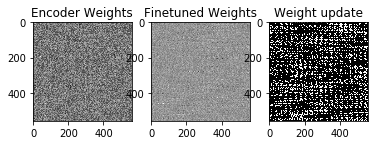

In [10]:
cll_weights_ft = copy.deepcopy(net[0][0].weight.data)

cll_weights = (1 + cll_weights)*127.5
cll_weights_ft = (1 + cll_weights_ft)*127.5

if use_gpu:
    cll_weights = cll_weights.view(-1,28*20,28*20).byte().cpu()
    cll_weights_ft = cll_weights_ft.view(-1,28*20,28*20).byte().cpu()
else:
    cll_weights = cll_weights.view(-1,28*20,28*20).byte()
    cll_weights_ft = cll_weights_ft.view(-1,28*20,28*20).byte()

d_weights = cll_weights - cll_weights_ft

fig = plt.figure()
plot=fig.add_subplot(1,3,1)
img = np.array(cll_weights.numpy())[0]
plot.set_title('Encoder Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,2)
img = np.array(cll_weights_ft.numpy())[0]
plot.set_title('Finetuned Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,3)
img = np.array(d_weights.numpy())[0]
plot.set_title('Weight update')
imgplot = plt.imshow(img,cmap='gray')
plt.show()

Classifier Weights Visualization:
=======================

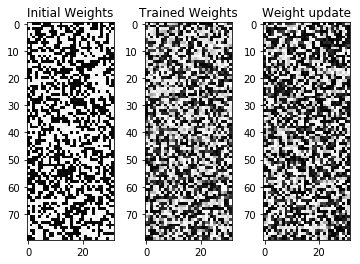

In [11]:
trained_classifier_weights = copy.deepcopy(net.classifier[0].weight.data)

init_classifier_weights = (1 + init_classifier_weights)*255
trained_classifier_weights = (1 + trained_classifier_weights)*255

if use_gpu:
    init_classifier_weights = init_classifier_weights.view(-1,80,32).byte().cpu()
    trained_classifier_weights = trained_classifier_weights.view(-1,80,32).byte().cpu()
else:
    init_classifier_weights = init_classifier_weights.view(-1,80,32).byte()
    trained_classifier_weights = trained_classifier_weights.view(-1,80,32).byte()

d_weights = init_classifier_weights - trained_classifier_weights

fig = plt.figure()
plot=fig.add_subplot(1,3,1)
img = np.array(init_classifier_weights.numpy())[0]
plot.set_title('Initial Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,2)
img = np.array(trained_classifier_weights.numpy())[0]
plot.set_title('Trained Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,3)
img = np.array(d_weights.numpy())[0]
plot.set_title('Weight update')
imgplot = plt.imshow(img,cmap='gray')
plt.show()

Performance of different Classes:
==================

In [12]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    if use_gpu:
        outputs = net(Variable(images.view(-1, 28*28).double().cuda()))
        _, predicted = torch.max(outputs.data.cpu(), 1)
    else:
        outputs = net(Variable(images.view(-1, 28*28).double()))
        _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %f %%' % (
        classes[i], 100 * class_correct[i] / float(class_total[i])))

Accuracy of  zero : 100.000000 %
Accuracy of   one : 97.916667 %
Accuracy of   two : 100.000000 %
Accuracy of three : 100.000000 %
Accuracy of  four : 100.000000 %
Accuracy of  five : 100.000000 %
Accuracy of   six : 100.000000 %
Accuracy of seven : 95.121951 %
Accuracy of eight : 97.368421 %
Accuracy of  nine : 92.500000 %
